# Acetylene pyrolysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext majordome.skipper

In [3]:
from majordome import (
    NormalFlowRate,
    PlugFlowChainCantera,
    get_reactor_data,
)
from scipy.interpolate import CubicSpline
import os
import cantera as ct
import numpy as np
import pandas as pd

In [4]:
ct.suppress_thermo_warnings(suppress=True)

os.environ["MJ_SOLVE_FINEST"] = "true"

## Toolbox

In [5]:
class TubularReactor:
    """ Provides the discretization of a tubular reactor. """
    def __init__(self, L=0.52, D=0.028, d=0.01):
        self.D = D
        self.A_cell = d * np.pi * D
        self.V_cell = d * np.pi * (D/2)**2

        self.z = np.arange(d/2, L-d/2+0.1*d, d)
        self.V = np.full_like(self.z, self.V_cell)

In [6]:
def mass_flow_rate(mechanism, X, qdot, verbose):
    """ Evaluate mass flow rate from mechanism [kg/s]. """
    nfr = NormalFlowRate(mechanism, X=X)
    if verbose:
        print(nfr.report(qdot=qdot))
    return nfr(qdot)

In [7]:
def initial_mixture(sol, fraction):
    """ Compute mixture accounting for imputiries. """
    if "CH3COCH3" in sol.species_names:
        X = {"C2H2"     : 0.980 * fraction,
             "CH4"      : 0.002 * fraction,
             "CH3COCH3" : 0.018 * fraction}
    else:
        X = {"C2H2"     : 0.998 * fraction,
             "CH4"      : 0.002 * fraction}

    X["N2"] = 1.0 - sum(X.values())
    return X

In [8]:
def global_htc(reactor, sol, Nu):
    """ Evaluate global heat transfer coefficient. """
    try:
        k = sol.thermal_conductivity
    except:
        k = 0.025 # Norinaga lacks transport!
    return reactor.A_cell * Nu * k / reactor.D

In [9]:
def solve(mechanism, fraction, qdot, P, T_wall, *, T_env=298.15,
          K=0.01, Nu=3.66, verbose=False, **kwargs):
    """ Integrate reactor model with given operating conditions. """
    # -- HANDLE UNITS
    P    *= 100           # hPa to Pa
    qdot *= 1.0e-06 * 60  # SCCM to Nm³/h

    # -- CREATE PROBLEM
    reactor = TubularReactor()
    
    sol = ct.Solution(mechanism)
    sol.TPX = T_env, P, initial_mixture(sol, fraction)

    mdot = mass_flow_rate(mechanism, sol.X, qdot, verbose)
    apfr = PlugFlowChainCantera(sol.source, sol.name, reactor.z,
                                reactor.V, P=sol.P, K=K)

    ## -- SETUP CONDITIONS
    sources = get_reactor_data(apfr)
    sources.m[0] = mdot
    sources.h[0] = sol.h
    sources.Y[0, :] = sol.Y
    sources.Q[:] = 0

    ## -- REGISTER HEAT TRASNFER
    def heat_flow(i, T):
        U = global_htc(reactor, sol, Nu)
        Q = -U * (T - T_wall(reactor.z[i]))
        return Q

    apfr.register_heat_flow(heat_flow)

    ## -- SOLVE AND PROCESS
    apfr.update(sources)

    cols = kwargs.get("cols", ["z_cell", "Q_cell", "T", "X"])
    data = apfr.states.to_pandas(cols=cols)
    
    return apfr, data

In [10]:
def plot_reactor(apfr):
    config = dict(selected=["C2H2"], y_label="Mole fraction",
                  composition_variable="X")

    plot = apfr.quick_plot(**config)
    plot.axes[0].legend(loc=3)

In [11]:
MECHS = ["c2h2/dalmazsi-2017.yaml",
         "c2h2/graf-2007.yaml",
         "c2h2/norinaga-2009.yaml"]

PROFILES = pd.DataFrame({
    "z":    [ 0.00,   0.05,   0.10,   0.12,   0.15,   0.20, 0.25,
              0.30,   0.35,   0.40,   0.45,   0.50,   0.52  ],
    "773":  [ 298.0,  303.0,  330.0,  400.0,  650.0,  750.0, 762.0,
              763.0,  763.0,  763.0,  582.0,  440.0,  400.0 ],
    "873":  [ 298.0,  299.0,  360.0,  503.0,  757.0,  834.0, 850.0,
              869.0,  859.0,  849.0,  698.0,  546.0,  400.0 ],
    "973":  [ 298.0,  299.0,  420.0,  653.0,  873.0,  918.0, 949.0,
              971.0,  954.0,  937.0,  780.0,  623.0,  400.0 ],
    "1023": [ 298.0,  299.0,  550.0,  689.0,  896.0,  965.0, 1001.0,
             1018.0, 1001.0,  984.0,  837.0,  690.0,  400.0 ],
    "1073": [ 298.0,  299.0,  550.0,  726.0,  919.0, 1013.0, 1052.0,
             1064.0, 1048.0, 1031.0,  894.0,  757.0,  400.0 ],
    "1123": [ 298.0,  299.0,  550.0,  755.0,  959.0, 1057.0, 1098.0,
             1110.0, 1095.0, 1080.0,  931.0,  782.0,  400.0 ],
    "1173": [ 298.0,  299.0,  550.0,  783.0, 1000.0, 1101.0, 1143.0,
             1156.0, 1143.0, 1129.0,  968.0,  806.0,  400.0 ],
    "1223": [ 298.0,  299.0,  550.0,  793.0, 1048.0, 1151.0, 1189.0,
             1205.0, 1189.0, 1172.0,  991.0,  809.0,  400.0 ],
    "1273": [ 298.0,  299.0,  550.0,  803.0, 1095.0, 1200.0, 1235.0,
             1253.0, 1234.0, 1214.0, 1013.0,  811.0,  400.0 ],
})

## Reference case

In [12]:
%%skipper MJ_SOLVE_FINEST
%%time
results, df = solve(MECHS[2], fraction=0.36, qdot=222, P=50,
                    T_wall=CubicSpline(PROFILES["z"], PROFILES["1173"]))
plot_reactor(results)

Skipping cell: MJ_SOLVE_FINEST=True


CPU times: user 710 ms, sys: 17.6 ms, total: 728 ms
Wall time: 709 ms


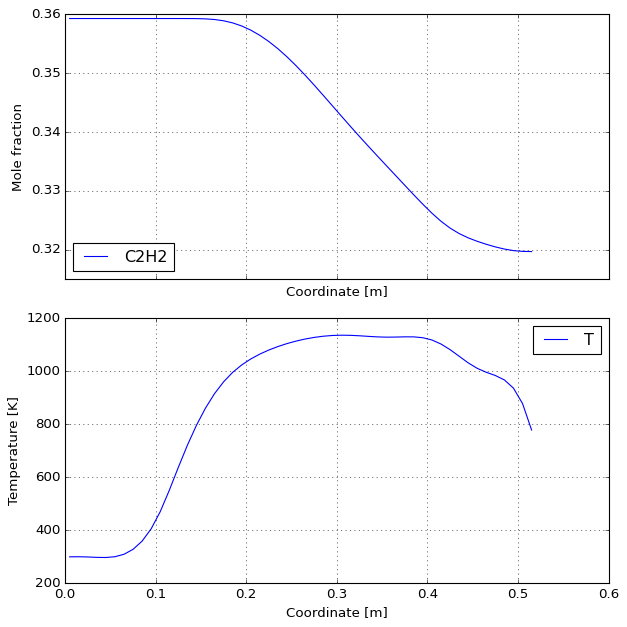

In [13]:
%%time
results, df = solve(MECHS[1], fraction=0.36, qdot=222, P=50,
                    T_wall=CubicSpline(PROFILES["z"], PROFILES["1173"]))
plot_reactor(results)

CPU times: user 1.67 s, sys: 20.8 ms, total: 1.69 s
Wall time: 1.68 s


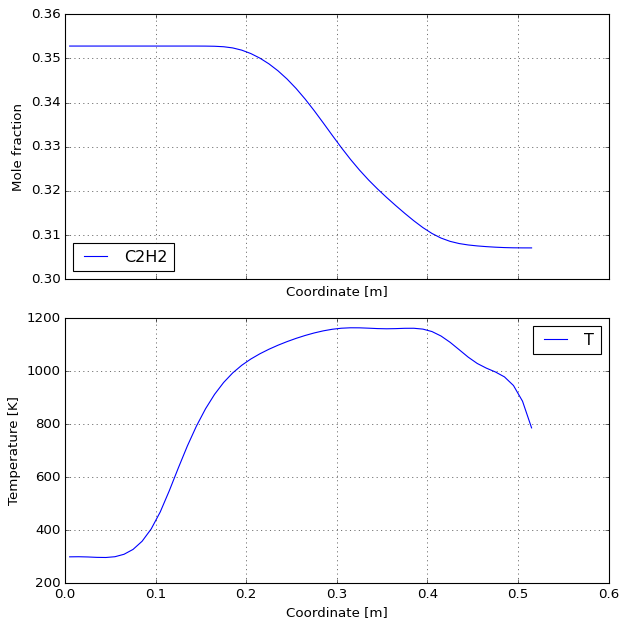

In [14]:
%%time
results, df = solve(MECHS[0], fraction=0.36, qdot=222, P=50,
                    T_wall=CubicSpline(PROFILES["z"], PROFILES["1173"]))
plot_reactor(results)

## Scan table

In [15]:
TABLE5_9 = [
    dict(N= 1, P= 50, Q=222, T= 773, X_meas=0.352),
    dict(N= 2, P= 50, Q=222, T= 873, X_meas=0.364),
    dict(N= 3, P= 50, Q=222, T= 973, X_meas=0.364),
    dict(N= 4, P= 50, Q=222, T=1073, X_meas=0.346),
    dict(N= 5, P= 50, Q=222, T=1123, X_meas=0.312),
    dict(N= 6, P= 50, Q=222, T=1173, X_meas=0.307),
    dict(N= 7, P= 50, Q=222, T=1273, X_meas=0.288),
    dict(N= 8, P= 30, Q=222, T=1173, X_meas=0.323),
    dict(N= 9, P= 30, Q=222, T=1223, X_meas=0.314),
    dict(N=10, P=100, Q=222, T=1173, X_meas=0.249),
    dict(N=11, P=100, Q=222, T=1223, X_meas=0.226),
    dict(N=12, P=100, Q=222, T=1273, X_meas=0.201),
    dict(N=13, P=100, Q=378, T=1023, X_meas=0.343),
    dict(N=14, P=100, Q=378, T=1123, X_meas=0.298),
]

In [16]:
def scan_with_mech(mech):
    table = TABLE5_9.copy()
    for k, row in enumerate(TABLE5_9):
        print(f"Working on case no. {k+1}")

        T_name = str(int(row["T"]))
        _, df = solve(mech, fraction=0.36, qdot=row["Q"], P=row["P"],
                      T_wall=CubicSpline(PROFILES["z"], PROFILES[T_name]))

        table[k]["X_calc"] = float(df["X_C2H2"].iloc[-1])

    return pd.DataFrame(table)

In [17]:
def run_mech(mech, df=None):
    name = mech.split("/")[1].split(".")[0].replace("-", "_")
    x_name, e_name = f"X_{name}", f"err_{name}"
    
    scan = scan_with_mech(mech).rename(columns={"X_calc": x_name})

    if df is None:
        df = scan

    df[e_name] = 100 * (scan[x_name] / scan["X_meas"] - 1)

    return df

In [18]:
%%time
df = run_mech(MECHS[0], df=None)

Working on case no. 1


Working on case no. 2


Working on case no. 3


Working on case no. 4


Working on case no. 5


Working on case no. 6


Working on case no. 7


Working on case no. 8


Working on case no. 9


Working on case no. 10


Working on case no. 11


Working on case no. 12


Working on case no. 13


Working on case no. 14


CPU times: user 22.3 s, sys: 125 ms, total: 22.4 s
Wall time: 22.3 s


In [19]:
%%time
df = run_mech(MECHS[1], df=df)

Working on case no. 1


Working on case no. 2


Working on case no. 3
Working on case no. 4


Working on case no. 5


Working on case no. 6


Working on case no. 7


Working on case no. 8
Working on case no. 9


Working on case no. 10
Working on case no. 11
Working on case no. 12


Working on case no. 13
Working on case no. 14


CPU times: user 8.48 s, sys: 220 ms, total: 8.7 s
Wall time: 8.5 s


In [20]:
%%skipper MJ_SOLVE_FINEST
%%time
df = run_mech(MECHS[2], df=df)

Skipping cell: MJ_SOLVE_FINEST=True


In [21]:
df

N    P    Q     T  X_meas  X_dalmazsi_2017  err_dalmazsi_2017  \
0    1   50  222   773   0.352         0.352786           0.223212   
1    2   50  222   873   0.364         0.352540          -3.148330   
2    3   50  222   973   0.364         0.350258          -3.775208   
3    4   50  222  1073   0.346         0.339812          -1.788298   
4    5   50  222  1123   0.312         0.326556           4.665512   
5    6   50  222  1173   0.307         0.307034           0.010994   
6    7   50  222  1273   0.288         0.290866           0.995060   
7    8   30  222  1173   0.323         0.329143           1.901911   
8    9   30  222  1223   0.314         0.318436           1.412680   
9   10  100  222  1173   0.249         0.242491          -2.613868   
10  11  100  222  1223   0.226         0.230372           1.934472   
11  12  100  222  1273   0.201         0.221251          10.075293   
12  13  100  378  1023   0.343         0.342777          -0.065090   
13  14  100  378  1123   0.298         0.305793           2.615003   

    err_graf_2007  
0        2.032933  
1       -1.550413  
2       -2.602299  
3       -1.188026  
4        6.179187  
5        4.120820  
6        6.743916  
7        5.859843  
8        7.828360  
9        4.125649  
10       5.944962  
11      12.714431  
12       0.254930  
13       6.255879

In [22]:
error_cols = [c for c in df.columns if c.startswith("err")]
rmse_frame = np.sqrt((df[error_cols]**2).mean())

pd.DataFrame(rmse_frame).T

err_dalmazsi_2017  err_graf_2007
0            3.53261       5.758262